
# MAvis Experimentation Notebook

This notebook is designed to help you experiment with different search-based methods in AI. You will be tasked to implement different search strategies, both uninformed and informed, and to use this notebook to run benchmarks. It integrates functionalities from your Python modules and the Mavis Level Designer.

### Features:
- Load and edit levels using the [Mavis Level Designer](https://sebastianrmason.github.io/mavis-level-designer/).
- Experiment with search algorithms such as BFS, DFS and more.
- Explore heuristics and their impact on the performance of informed search methods.
- Visualize search progress and results.

In [10]:
# Import necessary modules from your files
import os
import subprocess
import numpy as np

from tqdm.notebook import tqdm

from searchclient.agent_types.classic import * 

# Import all action classes (used for hardcoding solutions) and actions libraries
from searchclient.domains.hospital.actions import (
    NoOpAction, MoveAction, PushAction, PullAction, AnyAction, DEFAULT_MAPF_ACTION_LIBRARY, DEFAULT_HOSPITAL_ACTION_LIBRARY
)

# Import state, goal description and level classes for the MAvis hospital environment
from searchclient.domains.hospital.state import HospitalState
from searchclient.domains.hospital.goal_description import HospitalGoalDescription
from searchclient.domains.hospital.level import HospitalLevel

# Import the Graph-Search algorithm
from searchclient.search_algorithms.graph_search import graph_search

# Import the different search strategies for both uninformed and informed search
from searchclient.strategies.bfs import FrontierBFS
from searchclient.strategies.dfs import FrontierDFS
from searchclient.strategies.bestfirst import FrontierBestFirst, FrontierGreedy, FrontierAStar

# Import heuristic classes, to be used in informed search methods
from searchclient.domains.hospital.heuristics import (
    HospitalZeroHeuristic, HospitalGoalCountHeuristics, HospitalAdvancedHeuristics
)

# Ensure the environment is set up properly
print("Modules imported successfully.")

Modules imported successfully.



## Level Design

You can use the [Mavis Level Designer](https://sebastianrmason.github.io/mavis-level-designer/) to create and edit levels.
Save the level as a `.lvl` file and upload it in thele `level` folder for experimentation.

In [11]:
# Function to load a level file
def load_level_file_from_path(path):
    with open(path, "r") as f:
        lines = f.readlines()
        lines = list(map(lambda line: line.strip(), lines))
        return lines
  
# Example usage: load_level('path_to_level_file.lvl')
level_path = "levels/MAPF00.lvl"
level_lines = load_level_file_from_path(level_path)
level = HospitalLevel.parse_level_lines(level_lines)

# We can access the initial state of the level using the following code
initial_state = HospitalState(level, level.initial_agent_positions, level.initial_box_positions)

# We can access the goal description of the level using the following code
goal_description = HospitalGoalDescription(level, level.box_goals + level.agent_goals)

print('The initial state of the level is:')
print(initial_state)

print('\nThe goal description of the level is:')
print(goal_description) # which tells us where the level objects (like boxes and agents) should be placed to satisfy the goal
print('\nSo agent zero starts at {} and satisfies the goal at {}'.format(level.initial_agent_positions[0][0], goal_description.agent_goals[0][0]))

The initial state of the level is:
++++++++++
+0       +
+     ++++
+        +
+     ++ +
+      + +
++++++++++

The goal description of the level is:
((5, 8), '0', True)

So agent zero starts at (1, 1) and satisfies the goal at (5, 8)


## Rendering states
Visualizing the states of your environment is an essential step in understanding the intricacies of your problem space. By rendering individual states, you can gain a better grasp of the initial setup, intermediate configurations, and goal states of your system. This approach not only helps debug your environment but also lays a foundation for interpreting plans and strategies more effectively.

Rendering states can be accomplished easily using the `render_state()` function in the PyGame rendering script. This function takes a level and single state as input and visualizes it, allowing you to observe key attributes and spatial layouts. For instance, you can analyze agent positions, obstacles, or other relevant features specific to your problem.

The function will save the rendered state as a `.png` file. Unless specified, the image will be saved as `rendered_state.png`. Below is an example on how to use it where we just save the initial state of the level above. 

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM default


State rendered and saved to give_me_a_name.png
++++++++++
+0       +
+     ++++
+        +
+     ++ +
+      + +
++++++++++


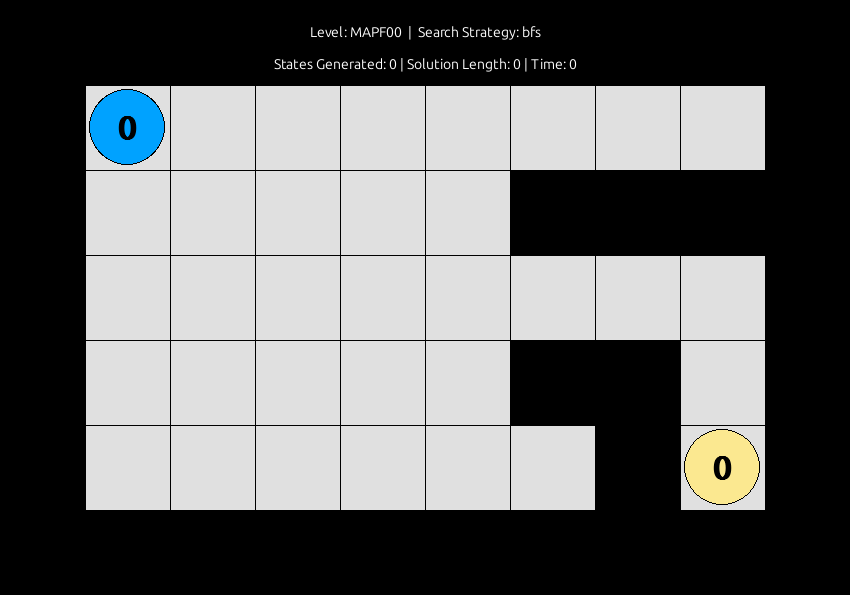

In [12]:
from PIL import Image
from renderState import *

# Render some state of the level (here the initial state)
render_state(level_path=level_path, state=initial_state, output_path='give_me_a_name')

# So the state looks like this in .txt format (what the computer uses):
print(initial_state)

# And the initial state looks like this in .png:
# You can either show the image in the notebook or open it in a new window
img = Image.open('give_me_a_name.png')
img.show()

## Rendering plans
Rendering your environment is a big part of gaining core insights about the theoretical challenges of certain problems. It helps you gain a conceptual understanding of your chosen approach much faster, and can also aid you in chosing your strategy. Below, we show you an easy way to send the plan found by graph search to the PyGame rendering script.

All we have to do is convert the plan returned by graph search to a string using the `convert_plan_to_string()` utility function, and then pass it to the `renderMAvis.py` script. Note that the first execution of the `render_plan()` function may take some time, but it typically runs much faster on subsequent attempts.

In [13]:
def render_plan(level_path, plan, strategy_name, heuristic_name, num_generated, elapsed_time, sol_length):

    str_plan = convert_plan_to_string(plan) #convert the plan to a string

    # this just makes sure that the meta information is displayed correctly in the visualization
    if strategy_name == 'greedy' or strategy_name == 'astar':
        strategy_name_pygame = strategy_name + ' w. ' + heuristic_name
    else:
        strategy_name_pygame = strategy_name
    
    subprocess.run(["python3", 
                    "renderMAvis.py", 
                    "--level", level_path, 
                    "--plan", str_plan, 
                    "--search_strategy", strategy_name_pygame, 
                    "--num_generated", str(num_generated), 
                    "--time_elapsed", str(elapsed_time), 
                    "--sol_length", str(sol_length)])

We can use the `render_plan` function to hardcode a solution to our problem. Since you will later use Graph-Search to automatically find plans, you can use this to familiarize yourself with the client, the actions class and other classes of the MAvis environment.

In [14]:
# Here is an example of a plan. A plan is a list of list of actions, where an action is an instance from searchclient.domains.hospital.actions
# The first axis of the list corresponds to a timestep in the plan. 
# Each element of the innermost list corresponds to an action of a different agent. 
# Check the documentation of graph_seach.py for more information!
hardcoded_plan = [[MoveAction("E")], [NoOpAction()], [MoveAction("W")]]

# Hardcode your solution here!
#hardcoded_plan = None

render_plan(level_path, hardcoded_plan, "Hardcoded sol", None, len(hardcoded_plan), "0.0", len(hardcoded_plan))

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM default


Finished executing the plan


## Executing Search Algorithms

In the following code we will be running the Graph-Search algorithm using a specified search strategy. 

You will have to implement the Graph-Search yourself after what you have seen in class. The implementation for the Bredth First Search (BFS) frontier is already available and you can use it as inspiration for coding other search strategies in the future.

Until Graph-Search is implemented, you are only able to hardcode a plan. Later on you can use the following pipeline to run experiments for the Mavis assignments. 


In [15]:
# Before running the search algorithm, we need to define the action set and the action library
# Use this library for pure pathfinding problems
action_library = DEFAULT_MAPF_ACTION_LIBRARY

# Use this library for sokoban-like problems (includes Push and Pull actions)
#action_library = DEFAULT_HOSPITAL_ACTION_LIBRARY

# Every agent will have the same action set
action_set = [action_library] * level.num_agents

# In order to run Graph-Search, we need to specify the initial state, action set, goal description, and frontier 

# If needed, we need to specify and fetch a heuristic function before initializing the frontier (informed search) 
# When adding new heuristics, remember to update the dictionary! 
# Use a string that matches the name of the heuristic function in the heuristics.py file
heuristic_name = "zero" 
heuristic = {
        'zero': HospitalZeroHeuristic,
        'goalcount': HospitalGoalCountHeuristics,
        'advanced': HospitalAdvancedHeuristics,
    }.get(heuristic_name, HospitalZeroHeuristic)() # make sure you understand what .get() does


# Finally, let's pick the search strategy and fetch the relevant frontier
strategy_name = "bfs" 
frontier = {
        'bfs': FrontierBFS,
        'dfs': FrontierDFS,
        'astar': lambda: FrontierAStar(heuristic),
        'greedy': lambda: FrontierGreedy(heuristic)
    }.get(strategy_name, FrontierBFS)() # make sure you understand what .get() does

In [16]:
# Now that we have defined the initial state, action set, goal description, and frontier, we can run the search algorithm
planning_success, plan, num_generated, elapsed_time = graph_search(initial_state, action_set, goal_description, frontier)

# The graph search function returns the following:
print('Planning successful:', planning_success)
print('Plan:', plan)
print('Solution length:', len(plan))
print('Number of states generated:', num_generated)
print('Elapsed time:', elapsed_time)

Planning successful: True
Plan: [[Move(E)], [Move(S)], [Move(S)], [Move(E)], [Move(E)], [Move(E)], [Move(E)], [Move(E)], [Move(E)], [Move(S)], [Move(S)]]
Solution length: 11
Number of states generated: 34
Elapsed time: 0,006


#Expanded:       34, #Frontier:        0, #Generated:       34, Time: 0,006 s, Memory: 102,38 MB




In [17]:
render_plan(level_path, plan, strategy_name, heuristic_name, num_generated, elapsed_time, len(plan))

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM default


Finished executing the plan


## Running multiple trials and statistical analysis of performance

In order to make more principled statements over the different algorithms' performance, we will provide you a pipeline to run $n$-trials over a given level. This will allow you to consider the average performance and their statistics instead of drawing conclusions from a singular example. 

**NOTE:** for complex levels with longer runtimes, it might not be feasible to run a high number of trials! Take this into consideration when running your experiments

In [18]:
# For easiness of use, let's redifine and reload everything  
level_path = "levels/MAPF00.lvl"
level_lines = load_level_file_from_path(level_path)
level = HospitalLevel.parse_level_lines(level_lines)

# We can access the initial state of the level using the following code
initial_state = HospitalState(level, level.initial_agent_positions, level.initial_box_positions)

# We can access the goal description of the level using the following code
goal_description = HospitalGoalDescription(level, level.box_goals + level.agent_goals)

print('The initial state of the level is:')
print(initial_state)

print('\nThe goal description of the level is:')
print(goal_description) # which tells us where the level objects (like boxes and agents) should be placed to satisfy the goal
print('\nSo agent zero starts at {} and satisfies the goal at {}'.format(level.initial_agent_positions[0][0], goal_description.agent_goals[0][0]))

The initial state of the level is:
++++++++++
+0       +
+     ++++
+        +
+     ++ +
+      + +
++++++++++

The goal description of the level is:
((5, 8), '0', True)

So agent zero starts at (1, 1) and satisfies the goal at (5, 8)


In [19]:
# Before running the search algorithm, we need to define the action set and the action library
# Use this library for pure pathfinding problems
action_library = DEFAULT_MAPF_ACTION_LIBRARY

# Use this library for sokoban-like problems (includes Push and Pull actions)
#action_library = DEFAULT_HOSPITAL_ACTION_LIBRARY

# Every agent will have the same action set
action_set = [action_library] * level.num_agents

# In order to run Graph-Search, we need to specify the initial state, action set, goal description, and frontier 

# If needed, we need to specify and fetch a heuristic function before initializing the frontier (informed search) 
# When adding new heuristics, remember to update the dictionary! 
# Use a string that matches the name of the heuristic function in the heuristics.py file
heuristic_name = "zero" 
heuristic = {
        'zero': HospitalZeroHeuristic,
        'goalcount': HospitalGoalCountHeuristics,
        'advanced': HospitalAdvancedHeuristics,
    }.get(heuristic_name, HospitalZeroHeuristic)() # make sure you understand what .get() does


# Finally, let's pick the search strategy and fetch the relevant frontier
strategy_name = "dfs" 
frontier = {
        'bfs': FrontierBFS,
        'dfs': FrontierDFS,
        'astar': lambda: FrontierAStar(heuristic),
        'greedy': lambda: FrontierGreedy(heuristic)
    }.get(strategy_name, FrontierBFS)() # make sure you understand what .get() does

In [20]:
n_trials = 10

plans, sol_lengths, generated, elapsed = [], [], [], []
for n in tqdm(range(n_trials)):
    planning_success, plan, num_generated, elapsed_time = graph_search(initial_state, action_set, goal_description, frontier)
    plans.append(plan)
    sol_lengths.append(len(plan))
    generated.append(int(num_generated))
    elapsed.append(elapsed_time)


# The graph search function returns the following:
print('Average solution legth:', np.mean(sol_lengths))
print('Solution length variance :', np.var(sol_lengths))
print('Average number of states generated:', np.mean(generated))
print('Number of states generated variance :', np.var(generated))

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
# In case you want to visualize the i-th trial

# Select trial to render
index_to_render = 0

# Render trial
render_plan(
    level_path,
    plans[index_to_render], 
    strategy_name, 
    heuristic_name, 
    generated[index_to_render],
    elapsed[index_to_render], 
    sol_lengths[index_to_render]
)




In [ ]:
#MAVIS 1.1

#simple
simple_debug_path = "levels/SimpleDebug.lvl"
simple_debug_lines = load_level_file_from_path(simple_debug_path)
simple_debug_lvl = HospitalLevel.parse_level_lines(simple_debug_lines) 

#initial state
simple_initial_state = HospitalState(simple_debug_lvl, simple_debug_lvl.initial_agent_positions, simple_debug_lvl.initial_box_positions)

# We can access the goal description of the level using the following code
simple_goal_description = HospitalGoalDescription(simple_debug_lvl, simple_debug_lvl.box_goals + simple_debug_lvl.agent_goals)

print('The initial state of the level is:')
print(simple_initial_state)

print('\nThe goal description of the level is:')
print(simple_goal_description) # which tells us where the level objects (like boxes and agents) should be placed to satisfy the goal
print('\nSo agent zero starts at {} and satisfies the goal at {}'.format(simple_debug_lvl.initial_agent_positions[0][0], simple_goal_description.agent_goals[0][0]))



print("\n\n")
print("-" * 30)
print("\n\n")
#double
two_agent_debug_path = "levels/TwoAgentsDebug.lvl"
two_agent_debug_lines = load_level_file_from_path(two_agent_debug_path)
two_agent_debug_lvl = HospitalLevel.parse_level_lines(two_agent_debug_lines)

#initial state
two_agent_initial_state = HospitalState(two_agent_debug_lvl, two_agent_debug_lvl.initial_agent_positions, two_agent_debug_lvl.initial_box_positions)
# We can access the goal description of the level using the following code
two_agent_goal_description = HospitalGoalDescription(two_agent_debug_lvl, two_agent_debug_lvl.box_goals + two_agent_debug_lvl.agent_goals)  
print('The initial state of the level is:')
print(two_agent_initial_state)
print('\nThe goal description of the level is:')
print(two_agent_goal_description) # which tells us where the level objects (like boxes and agents) should be placed to satisfy the goal
print('\nSo agent zero starts at {} and satisfies the goal at {}'.format(two_agent_debug_lvl.initial_agent_positions[0][0], two_agent_goal_description.agent_goals[0][0]))   
print(f"and agent one starts at {format(two_agent_debug_lvl.initial_agent_positions[1][0])} and satisfies the goal at {two_agent_goal_description.agent_goals[1][0]}")  


#visualization 
render_state(level_path=simple_debug_path, state=simple_initial_state, output_path='simple_initial_state')
render_state(level_path=two_agent_debug_path, state=two_agent_initial_state, output_path='two_agent_debug_initial_state')

# So the state looks like this in .txt format (what the computer uses):
img_simple = Image.open('simple_initial_state.png')
img_double = Image.open('two_agent_debug_initial_state.png')
# And the initial state looks like this in .png:
# You can either show the image in the notebook or open it in a new window




#Actions + Sequences 


# Before running the search algorithm, we need to define the action set and the action library
# Use this library for pure pathfinding problems
action_library = DEFAULT_MAPF_ACTION_LIBRARY

# Every agent will have the same action set
action_set_simple = [action_library] * simple_debug_lvl.num_agents
action_set_two_agent = [action_library] * two_agent_debug_lvl.num_agents 

# In order to run Graph-Search, we need to specify the initial state, action set, goal description, and frontier 

# If needed, we need to specify and fetch a heuristic function before initializing the frontier (informed search) 
# When adding new heuristics, remember to update the dictionary! 
# Use a string that matches the name of the heuristic function in the heuristics.py file

heuristic = HospitalZeroHeuristic()

strategy_name = "bfs" 
frontier = FrontierBFS()


# Now that we have defined the initial state, action set, goal description, and frontier, we can run the search algorithm

#simple 
planning_success_simple, plan_simple, num_generated_simple, elapsed_time_simple = graph_search(simple_initial_state, action_set_simple, simple_goal_description, frontier)
planning_success_two_agent, plan_two_agent, num_generated_two_agent, elapsed_time_two_agent = graph_search(two_agent_initial_state, action_set_two_agent, two_agent_goal_description, frontier)


print("Simple level planning success:", planning_success_simple, "Plan:", plan_simple, "Number of states generated:", num_generated_simple, "Elapsed time:", elapsed_time_simple)

print("Two agent level planning success:", planning_success_two_agent, "Plan:", plan_two_agent, "Number of states generated:", num_generated_two_agent, "Elapsed time:", elapsed_time_two_agent)

render_plan(simple_debug_path, plan_simple, strategy_name, "zero", num_generated_simple, elapsed_time_simple, len(plan_simple))
render_plan(two_agent_debug_path, plan_two_agent, strategy_name, "zero", num_generated_two_agent, elapsed_time_two_agent, len(plan_two_agent))



#part E-> STATE approximations 
#simple
#4 possible states. Agent can be in either of 4 cells in the grid. 

#Two-agent 
#18 * 17 * 16 possible states. 
#This approximation of the state space assumes that no 2 agents may be on the same cell. 
#18 possible cells for agent 1, 17 for agent 2, and 16 for agent 3 to avoid the agents being on the same cell. 


#part F-> 

#load in levels/unreachable.lvl using the same level-loading code as before 
unreachable_debug_path = "levels/unreachable.lvl"
unreachable_debug_lines = load_level_file_from_path(unreachable_debug_path)
unreachable_debug_lvl = HospitalLevel.parse_level_lines(unreachable_debug_lines)

unreachable_initial_state = HospitalState(unreachable_debug_lvl, unreachable_debug_lvl.initial_agent_positions, unreachable_debug_lvl.initial_box_positions)
print(unreachable_initial_state)
#for this level the full state space is a poor approximation for the actual search space. I know this because the walls of the level are positioned in such a way that the 3 cells in the 4th column are unreachable in the search space despite being included in the calculation of the full state space. 


#part G-> 

#Changing the position of the goal does not alter the state space, as the state space identifies all legal configurations of the level. 
#For instance, suppose we have a 1-agent level in a 10x10 level (for simplicity let's assume that there are no walls within the borders of the level). Let's also assume that the 1 agent starts at 1,1. 
#Changing the goal postiion, for example, from 1,4 to 3,4 does not change the state space because the agent can still legally be in the cell with the goal . Because the goal is prefixed at the start of the level and does not affect where the agent can be positioned within the level,
#it must follow that the position of the goal does not influence the state space. 
